**Code Summary**
The following block of code will read in fastq files (able to read in as batch in a folder) and partial left and right adapter sequences or even when no adaptor sequences and extract insert sequence of interest. Extracted sequences are aligned and counted against template sequences provided as a fasta/csv file. Mapping statistic are output in a consolidated csv file.
  
**Used case**
1) Replace FASTQ_FILE with your input file (fastq or fastqz) or point to the folder that contains input files.
2) Replace TEMPLATE_FILE with your template file (fasta).
3) Set and adjust parameters before running the code.

**Format of input fasta file**<br>
\>Name_of_template_sequence_1<br>
Template_Sequence_1<br>
...

**Functionality**  
1) With partial left and right adapter sequences provided, insert sequence of interest is assumed to be immediately adjacent to the adapter sequences.
2) With no adapter sequences provided, the code will infer the adapter sequences and extract insert sequences.
3) Extracted sequences will be aligned to the provided template sequences and counted.    
4) The code allows for mismatch thresholds (Hamming / Levenshtein); Deafult Hamming = 2 and LEVENSHTEIN = 3.
5) Aligned reads are tracked and plotted.<br>
   ***Mapped reads per template:*** Percent reads that mapped to each template.<br>
   ***adapter matched type:*** Percent reads that has strict (complete matching), mixed (complete/partial matching) or fuzzy adapters (partial matching).<br>
   ***dist_distributions:*** Records distances for each alignment method (Hamming or Levenshtein)<br>
7) Read retention statistics are also output in a csv file.
8) Other statistics in csv output include:<br>
    ***Total reads, strict, mixed, fuzzy, rc_reads, mapped, unmapped in counts and in percent***<br>

In [22]:
#Define working directory
import os
os.chdir('/Users/LMWee/Code/Count')
os.getcwd()

'/Users/LMWee/Code/Count'

Statistics written to /Users/LMWee/Code/Count/Q3G6K3/all_samples_stats.csv


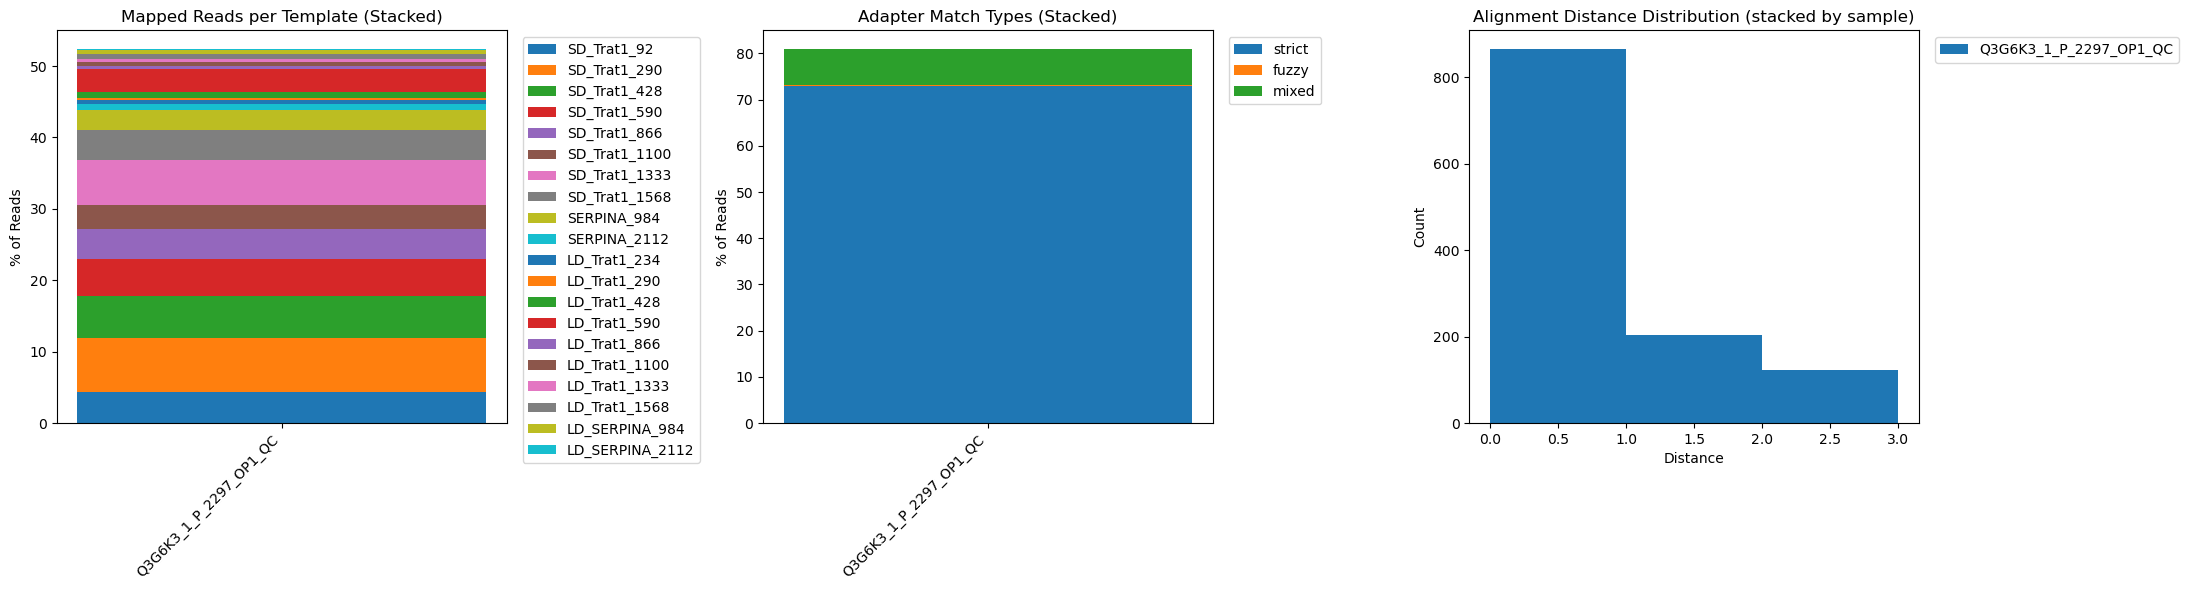

In [23]:
import os
import gzip
from collections import Counter, defaultdict
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from Bio import SeqIO
from Bio.Seq import Seq
from Levenshtein import distance as levenshtein

# ============================
# Parameters
# ============================
INPUT_FOLDER = "/Users/LMWee/Code/Count/Q3G6K3"   # folder containing .fastq or .fastq.gz files
TEMPLATE_FILE = "/Users/LMWee/Code/Count/Q3G6K3/OP1_Template.fasta"         # or "templates.csv"

LEFT_ADAPTER  = "ATTAAGGGCCTGCAGGGTGGA"  # if None -> auto infer
RIGHT_ADAPTER = "TCTACTCGAGGGGCTAGCCAG"  # if None -> auto infer
STRICT_ADAPTER = False
MAX_MISMATCHES = 2

ALLOW_HAMMING      = 2
ALLOW_LEVENSHTEIN  = 3

COMBINED_PLOTS  = True   # True = combined plots across all samples, False = separate per sample
PLOT_AS_PERCENT = True  # True = plot normalized to percent, False = raw counts
DIST_PLOT_MODE  = "by_sample"  # currently only by_sample implemented

# ============================
# Helper Functions
# ============================
def standardize_seq(seq: str) -> str:
    """Convert to uppercase DNA (U->T)."""
    return seq.upper().replace("U", "T")

def hamming_distance(s1, s2):
    if len(s1) != len(s2):
        return float("inf")
    return sum(ch1 != ch2 for ch1, ch2 in zip(s1, s2))

def find_fuzzy(seq, adapter, max_mismatches=2):
    best_pos, best_mismatches = None, None
    for i in range(0, len(seq) - len(adapter) + 1):
        window = seq[i:i+len(adapter)]
        mismatches = sum(1 for a, b in zip(window, adapter) if a != b)
        if mismatches <= max_mismatches:
            if best_mismatches is None or mismatches < best_mismatches:
                best_pos, best_mismatches = i, mismatches
    return best_pos, best_mismatches

def trim_adapters(read, left_adapter, right_adapter, strict=True, max_mismatches=2):
    """
    Find adapter positions with per-end strict/fuzzy classification.
    Returns (insert, match_type) where match_type in {"strict","mixed","fuzzy"} or (None, None).
    """

    # Strict positions
    li_strict = read.find(left_adapter)
    ri_strict = read.rfind(right_adapter)  # use rfind to favor the last right adapter

    left_is_strict  = (li_strict != -1)
    right_is_strict = (ri_strict != -1)

    # Fuzzy positions (can coincide with strict @ 0 mismatches)
    li_fuzzy, _ = find_fuzzy(read, left_adapter, max_mismatches=max_mismatches)
    ri_fuzzy, _ = find_fuzzy(read, right_adapter, max_mismatches=max_mismatches)

    left_has_pos  = left_is_strict or (li_fuzzy is not None)
    right_has_pos = right_is_strict or (ri_fuzzy is not None)

    # Helper to get chosen positions for each end given desired mode
    def get_positions(use_left_strict, use_right_strict):
        L = li_strict if use_left_strict  else li_fuzzy
        R = ri_strict if use_right_strict else ri_fuzzy
        return L, R

    # 1) Both strict → "strict"
    if left_is_strict and right_is_strict:
        if li_strict < ri_strict:
            insert = read[li_strict + len(left_adapter) : ri_strict]
            return insert, "strict"
        # Overlap or reversed → fall through to try mixed/fuzzy

    # 2) Exactly one strict and the other fuzzy → "mixed"
    if left_is_strict and (ri_fuzzy is not None):
        L, R = get_positions(True, False)
        if L is not None and R is not None and L < R:
            insert = read[L + len(left_adapter) : R]
            return insert, "mixed"

    if right_is_strict and (li_fuzzy is not None):
        L, R = get_positions(False, True)
        if L is not None and R is not None and L < R:
            insert = read[L + len(left_adapter) : R]
            return insert, "mixed"

    # 3) Both fuzzy → "fuzzy" (only if strict==False)
    if not strict and (li_fuzzy is not None) and (ri_fuzzy is not None) and (li_fuzzy < ri_fuzzy):
        insert = read[li_fuzzy + len(left_adapter) : ri_fuzzy]
        return insert, "fuzzy"

    # No valid orientation
    return None, None


def detect_and_orient_read(read, left_adapter, right_adapter, strict=True, max_mismatches=2):
    """Detect orientation, trim adapters, return insert, match_type, rc_flag."""
    insert, match_type = trim_adapters(read, left_adapter, right_adapter, strict, max_mismatches)
    if insert:
        return insert, match_type, False

    # Try reverse complement
    rc_read = str(Seq(read).reverse_complement())
    insert, match_type = trim_adapters(rc_read, left_adapter, right_adapter, strict, max_mismatches)
    if insert:
        return insert, match_type, True

    return None, None, False

def align_read(read, templates, max_hamming, max_levenshtein):
    best_template = None
    best_dist = float("inf")
    method = None
    for tname, tseq in templates.items():
        if len(read) == len(tseq):
            d = hamming_distance(read, tseq)
            if d <= max_hamming and d < best_dist:
                best_template, best_dist, method = tname, d, "hamming"
        # Always allow Levenshtein as fallback
        d = levenshtein(read, tseq)
        if d <= max_levenshtein and d < best_dist:
            best_template, best_dist, method = tname, d, "levenshtein"
    return best_template, best_dist, method

def output_basename(input_file):
    base = os.path.basename(input_file)
    if base.endswith(".fastq.gz"):
        base = base[:-9]
    elif base.endswith(".fastq"):
        base = base[:-6]
    return base

# ============================
# Load Templates
# ============================
templates = {}
if TEMPLATE_FILE.endswith(".fasta"):
    for rec in SeqIO.parse(TEMPLATE_FILE, "fasta"):
        templates[rec.id] = standardize_seq(str(rec.seq))
elif TEMPLATE_FILE.endswith(".csv"):
    df = pd.read_csv(TEMPLATE_FILE)
    templates = {row[0]: standardize_seq(str(row[1])) for row in df.itertuples(index=False)}
else:
    raise ValueError("TEMPLATE_FILE must be a .fasta or .csv")

# ============================
# Processing
# ============================
all_rows = []
# all_dist_distributions[sample] = list of distances (combined across methods)
all_dist_distributions = defaultdict(list)

for file in os.listdir(INPUT_FOLDER):
    if not (file.endswith(".fastq") or file.endswith(".fastq.gz")):
        continue

    fastq_path = os.path.join(INPUT_FOLDER, file)
    sample = output_basename(file)

    # Load reads
    if fastq_path.endswith(".gz"):
        with gzip.open(fastq_path, "rt") as handle:
            reads = [standardize_seq(str(rec.seq)) for rec in SeqIO.parse(handle, "fastq")]
    else:
        reads = [standardize_seq(str(rec.seq)) for rec in SeqIO.parse(fastq_path, "fastq")]

    stats = Counter()
    aligned_counts = Counter()
    match_type_counts = Counter()
    rc_count = 0

    for read in reads:
        stats["total"] += 1

        insert, match_type, rc_flag = detect_and_orient_read(
            read, LEFT_ADAPTER, RIGHT_ADAPTER, strict=STRICT_ADAPTER, max_mismatches=MAX_MISMATCHES
        )

        if insert is None:
            stats["discard_adapter"] += 1
            continue

        stats["kept_after_adapter"] += 1
        if match_type:
            match_type_counts[match_type] += 1
        if rc_flag:
            rc_count += 1

        best_template, dist, method = align_read(insert, templates, ALLOW_HAMMING, ALLOW_LEVENSHTEIN)
        if best_template is None:
            stats["unmapped"] += 1
        else:
            stats["mapped"] += 1
            aligned_counts[best_template] += 1
            # Track distance distribution by sample (combine methods)
            if dist is not None and np.isfinite(dist):
                all_dist_distributions[sample].append(dist)

    # Build row for output
    row = {"sample": sample}
    for t in templates.keys():
        row[t] = int(aligned_counts[t])
    row["total"]  = int(stats["total"])
    row["strict"] = int(match_type_counts["strict"])
    row["fuzzy"]  = int(match_type_counts["fuzzy"])
    row["mixed"]  = int(match_type_counts["mixed"])
    row["rc_reads"] = int(rc_count)
    row["kept_after_adapter"] = int(stats["kept_after_adapter"])
    row["mapped"]   = int(stats["mapped"])
    row["unmapped"] = int(stats["unmapped"])
    all_rows.append(row)

# ============================
# Reporting
# ============================
df_out = pd.DataFrame(all_rows).fillna(0)

# Add percentages (safe divide)
def pct(n, d):
    return (np.divide(n, d, out=np.zeros_like(n, dtype=float), where=d!=0) * 100.0)

if not df_out.empty:
    for col in templates.keys():
        df_out[f"{col}_pct"] = np.round(pct(df_out[col].astype(float), df_out["total"].astype(float)), 2)

    df_out["strict_pct"] = np.round(pct(df_out["strict"].astype(float), df_out["total"].astype(float)), 2)
    df_out["fuzzy_pct"]  = np.round(pct(df_out["fuzzy"].astype(float),  df_out["total"].astype(float)), 2)
    df_out["mixed_pct"]  = np.round(pct(df_out["mixed"].astype(float),  df_out["total"].astype(float)), 2)
    df_out["rc_reads_pct"] = np.round(pct(df_out["rc_reads"].astype(float), df_out["total"].astype(float)), 2)
    df_out["kept_after_adapter_pct"] = np.round(pct(df_out["kept_after_adapter"].astype(float), df_out["total"].astype(float)), 2)
    df_out["mapped_pct"]   = np.round(pct(df_out["mapped"].astype(float),   df_out["total"].astype(float)), 2)
    df_out["unmapped_pct"] = np.round(pct(df_out["unmapped"].astype(float), df_out["total"].astype(float)), 2)

output_csv = os.path.join(INPUT_FOLDER, "all_samples_stats.csv")
df_out.to_csv(output_csv, index=False)
print(f"Statistics written to {output_csv}")

# ============================
# Visualization
# ============================
def _as_percent(values, total):
    total = np.array(total, dtype=float)
    values = np.array(values, dtype=float)
    with np.errstate(divide='ignore', invalid='ignore'):
        out = np.divide(values, total, where=total!=0) * 100.0
        out[np.isnan(out)] = 0.0
    return out

def plot_results(df, dist_distributions, combined=True, as_percent=False):
    """
    Plots:
      1) Mapped Reads per Template (stacked by template)
      2) Adapter Match Types (stacked strict/fuzzy/mixed)
      3) Alignment Distance Distribution (stacked by sample)
    If as_percent=True, bars are normalized to percent (y-axis is %).
    """
    if df.empty:
        print("No data to plot.")
        return

    template_cols = list(templates.keys())
    adapter_cols = ["strict", "fuzzy", "mixed"]

    if combined:
        fig, axes = plt.subplots(1, 3, figsize=(22, 6))

        # --- 1. Mapped Reads per Template (stacked) ---
        x = np.arange(len(df["sample"]))
        bottoms = np.zeros(len(x), dtype=float)
        total_for_norm = df["total"].values if as_percent else None
        axes[0].set_title("Mapped Reads per Template (Stacked)")
        axes[0].set_ylabel("% of Reads" if as_percent else "Read Count")
        axes[0].set_xticks(x)
        axes[0].set_xticklabels(df["sample"], rotation=45, ha="right")

        for t in template_cols:
            vals = df[t].values
            plot_vals = _as_percent(vals, total_for_norm) if as_percent else vals
            axes[0].bar(x, plot_vals, bottom=bottoms, label=t)
            bottoms += plot_vals
        axes[0].legend(bbox_to_anchor=(1.02, 1), loc='upper left')

        # --- 2. Adapter Match Types (stacked) ---
        x = np.arange(len(df["sample"]))
        bottoms = np.zeros(len(x), dtype=float)
        axes[1].set_title("Adapter Match Types (Stacked)")
        axes[1].set_ylabel("% of Reads" if as_percent else "Read Count")
        axes[1].set_xticks(x)
        axes[1].set_xticklabels(df["sample"], rotation=45, ha="right")

        for a in adapter_cols:
            vals = df[a].values
            plot_vals = _as_percent(vals, total_for_norm) if as_percent else vals
            axes[1].bar(x, plot_vals, bottom=bottoms, label=a)
            bottoms += plot_vals
        axes[1].legend(bbox_to_anchor=(1.02, 1), loc='upper left')

        # --- 3. Distance distributions (stacked histogram by sample) ---
        # Gather per-sample lists (only non-empty)
        sample_list = []
        dist_arrays = []
        for sample in df["sample"]:
            dists = dist_distributions.get(sample, [])
            if len(dists) > 0:
                sample_list.append(sample)
                dist_arrays.append(np.array(dists, dtype=int))

        if len(dist_arrays) > 0:
            # bins across all samples
            max_dist = int(max([arr.max() for arr in dist_arrays]))
            bins = np.arange(0, max_dist + 2)  # +1 inclusive, +1 for right-edge
            # stacked histogram — counts (percent here is less common; keep counts for interpretability)
            axes[2].hist(dist_arrays, bins=bins, stacked=True, label=sample_list)
            axes[2].set_title("Alignment Distance Distribution (stacked by sample)")
            axes[2].set_xlabel("Distance")
            axes[2].set_ylabel("Count")
            axes[2].legend(bbox_to_anchor=(1.02, 1), loc='upper left')
        else:
            axes[2].text(0.5, 0.5, "No distance data", ha='center', va='center', transform=axes[2].transAxes)
            axes[2].set_axis_off()

        plt.tight_layout()
        out_path = os.path.join(INPUT_FOLDER, "combined_plots.png")
        plt.savefig(out_path, dpi=300, bbox_inches="tight")
        plt.show()

    else:
        # Separate figure per sample
        for sample in df["sample"]:
            fig, axes = plt.subplots(1, 3, figsize=(22, 6))
            row = df[df["sample"] == sample].iloc[0]

            # 1) Template counts (stacked with a single bar)
            axes[0].bar(template_cols,
                        _as_percent([row[t] for t in template_cols], row["total"]) if as_percent else [row[t] for t in template_cols])
            axes[0].set_title(f"Mapped Reads per Template - {sample}")
            axes[0].set_ylabel("% of Reads" if as_percent else "Read Count")
            axes[0].tick_params(axis='x', rotation=45)

            # 2) Adapter match types
            axes[1].bar(adapter_cols,
                        _as_percent([row[a] for a in adapter_cols], row["total"]) if as_percent else [row[a] for a in adapter_cols])
            axes[1].set_title(f"Adapter Match Types - {sample}")
            axes[1].set_ylabel("% of Reads" if as_percent else "Read Count")

            # 3) Distance distributions (stacked by sample is irrelevant here; show sample-only histogram)
            dists = dist_distributions.get(sample, [])
            if len(dists) > 0:
                max_dist = int(max(dists))
                bins = np.arange(0, max_dist + 2)
                axes[2].hist(np.array(dists, dtype=int), bins=bins)
                axes[2].set_title(f"Alignment Distance Distribution - {sample}")
                axes[2].set_xlabel("Distance")
                axes[2].set_ylabel("Count")
            else:
                axes[2].text(0.5, 0.5, "No distance data", ha='center', va='center', transform=axes[2].transAxes)
                axes[2].set_axis_off()

            plt.tight_layout()
            out_path = os.path.join(INPUT_FOLDER, f"{sample}_plots.png")
            plt.savefig(out_path, dpi=300, bbox_inches="tight")
            plt.show()

# Run plotting (shown in notebooks and saved to disk)
plot_results(df_out, all_dist_distributions, combined=COMBINED_PLOTS, as_percent=PLOT_AS_PERCENT)
